In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

In [22]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [23]:
#Get specific data from dataset
train = dataset['train']
val = dataset['validation']

In [24]:
def get_tweet(data):
    # Get raw text and emotion label for the dataset
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [25]:
tweets, emLabels = get_tweet(train)

In [26]:
#DEFINE RANDOM GLOBAL VARIABLE FOR TESTS
randomIndex = random.randint(0, len(tweets))

In [27]:
def print_tweet(t, l):
    # Provided a list of tweets and a list of labels
    # Print a random tweet and its corresponding label
    print("tweet:\n", t[randomIndex])
    print("label:", l[randomIndex])
    print()

def print_tokenized(tokenizer, tweets):
    #Print a random tweet and its corresponding tokenized version
    print("tweet:\n", tweets[randomIndex])
    print("tokenized:", tokenizer.texts_to_sequences(tweets)[randomIndex])
    print()

In [28]:
print_tweet(tweets, emLabels)

tweet:
 i feel too overwhelmed to clean anything so i just let it all pile up until it makes my whole life feel like it is going to come crashing down around me and i am helpless to stop it
label: surprise



In [29]:
#Tokenize the tweets
from tensorflow.keras.preprocessing.text import Tokenizer

#Initialize the tokenizer to only consider the top 10000 most frequently used words.
#Anything not in the top 10000 will be considered a oov and will be tokenized as <UNK>.
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

In [30]:
#Tokenize the tweets dataset that was previously imported
tokenizer.fit_on_texts(tweets)

#Test tokenizer..
print("======Tokenizer Test======")
print_tokenized(tokenizer, tweets)

======Tokenizer Test======
tweet:
 i feel too overwhelmed to clean anything so i just let it all pile up until it makes my whole life feel like it is going to come crashing down around me and i am helpless to stop it
tokenized: [2, 3, 94, 238, 5, 1308, 166, 15, 2, 32, 207, 13, 36, 3939, 42, 332, 13, 152, 11, 258, 78, 3, 14, 13, 22, 87, 5, 182, 3234, 142, 128, 18, 4, 2, 24, 293, 5, 254, 13]



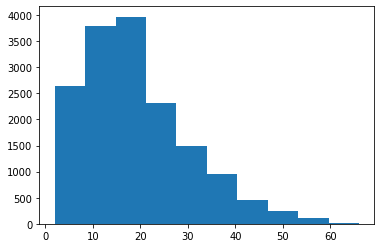

In [37]:
#Pad and truncate sequences from previous step
#We want to pad the sequences to the same length.
lengths = [len(tweet.split(' ')) for tweet in tweets]

#Analyze the histogram to determine a maximum length for the tweet
plt.hist(lengths)
plt.show()

In [38]:
maxlength = 50

In [39]:
#Begin padding the sequences to the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlength)
    return padded

padded_train_seq = get_sequences(tokenizer, tweets)

In [40]:
print("======Padded Test======")
print(tweets[randomIndex])
print(padded_train_seq[randomIndex])
print()

======Padded Test======
i feel too overwhelmed to clean anything so i just let it all pile up until it makes my whole life feel like it is going to come crashing down around me and i am helpless to stop it
[   2    3   94  238    5 1308  166   15    2   32  207   13   36 3939
   42  332   13  152   11  258   78    3   14   13   22   87    5  182
 3234  142  128   18    4    2   24  293    5  254   13    0    0    0
    0    0    0    0    0    0    0    0]



In [41]:
#Prepare the labels
classes = set(emLabels)

#Helper arrays to convert a label to a numerical representation
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in enumerate(classes))

#Convert our dataset labels to a numerical representation
names_to_ids = lambda labels: np.array([class_to_index.get(label) for label in labels])
train_labels = names_to_ids(emLabels)

In [42]:
print(class_to_index)

{'joy': 0, 'love': 1, 'fear': 2, 'anger': 3, 'surprise': 4, 'sadness': 5}


In [43]:
print(index_to_class)

{'joy': 0, 'love': 1, 'fear': 2, 'anger': 3, 'surprise': 4, 'sadness': 5}


In [44]:
#Build the model

#Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=maxlength),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
    ])

In [45]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [46]:
#Prepare validation set
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [47]:
#Train the model
history = model.fit(
    padded_train_seq,
    train_labels,
    validation_data=(val_seq, val_labels),
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/10
500/500 [==============================] - 23s 32ms/step - loss: 1.3104 - accuracy: 0.4797 - val_loss: 0.7866 - val_accuracy: 0.7160
Epoch 2/10
500/500 [==============================] - 21s 42ms/step - loss: 0.5673 - accuracy: 0.7934 - val_loss: 0.5548 - val_accuracy: 0.8070
Epoch 3/10
500/500 [==============================] - 23s 46ms/step - loss: 0.2760 - accuracy: 0.9104 - val_loss: 0.3871 - val_accuracy: 0.8750
Epoch 4/10
500/500 [==============================] - 26s 52ms/step - loss: 0.1677 - accuracy: 0.9467 - val_loss: 0.3903 - val_accuracy: 0.8750
Epoch 5/10
500/500 [==============================] - 34s 67ms/step - loss: 0.1224 - accuracy: 0.9623 - val_loss: 0.3785 - val_accuracy: 0.8900
Epoch 6/10
500/500 [==============================] - 30s 60ms/step - loss: 0.1014 - accuracy: 0.9686 - val_loss: 0.3640 - val_accuracy: 0.8855
Epoch 7/10
500/500 [==============================] - 31s 62ms/step - loss: 0.0910 - accuracy: 0.9715 - val_loss: 0.3724 - val_accuracy:

In [48]:

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


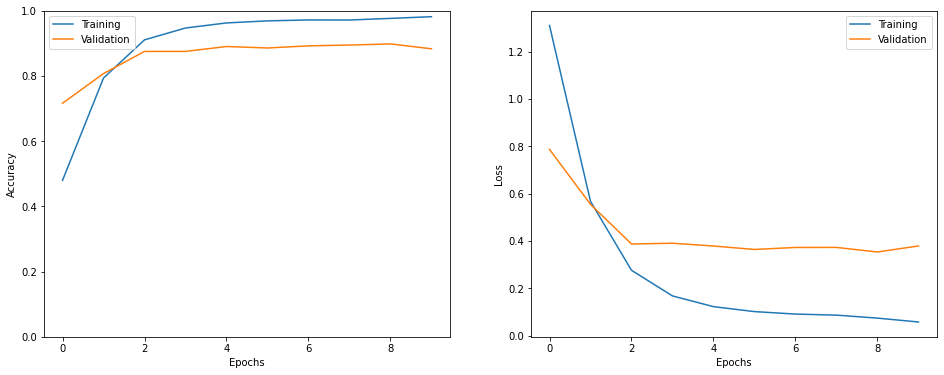

In [49]:

#Results
show_history(history)

In [50]:

#Test the model with a different dataset of tweets:
test_dataset = dataset['test']
test_tweets, test_labels = get_tweet(test_dataset)

In [51]:

#Evaluate the model on the test dataset. 
#test_tweets is the dataset that is being predicted.
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 19ms/step - loss: 0.3623 - accuracy: 0.8815


63/63 [==============================] - 3s 12ms/step


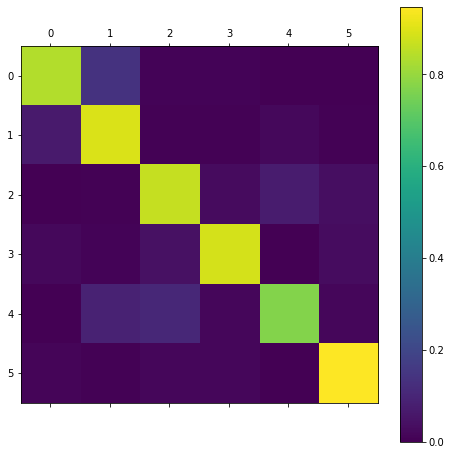

In [52]:
#Print the confusion matrix to check the accuracy of the model
predictions = model.predict(test_seq)
predictions = np.argmax(predictions, axis=-1)
show_confusion_matrix(test_labels, predictions, index_to_class.values())